#  Сегментация изображений

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation/data
* https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
* https://amaarora.github.io/posts/2020-09-13-unet.html
* https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
* https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8
* https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
* https://huggingface.co/docs/transformers/model_doc/segformer
* https://www.kaggle.com/code/damianpanek/segformerb0-people-clothing-segmentation

## Задачи для совместного разбора

1\. Рассмотрите пример работы слоя `ConvTranspose2d`.

In [1]:
import torch as th
import torch.nn as nn

In [4]:
img = th.arange(16).view(1, 1, 4, 4).float()
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
conv(img)

tensor([[[[3.1279, 3.9774],
          [6.5258, 7.3753]]]], grad_fn=<ConvolutionBackward0>)

In [5]:
img

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [6]:
img = th.arange(4).view(1, 1, 2, 2).float()
conv_t = nn.ConvTranspose2d(
    in_channels=1,
    out_channels=1,
    kernel_size=3,
    bias=False,
)
conv_t(img)

tensor([[[[ 0.0000, -0.0191,  0.0560,  0.0396],
          [-0.0383, -0.0675,  0.0895,  0.2006],
          [-0.2441, -0.7423, -0.1616, -0.0610],
          [-0.1225,  0.1103, -0.1723, -0.9200]]]],
       grad_fn=<ConvolutionBackward0>)

In [7]:
img

tensor([[[[0., 1.],
          [2., 3.]]]])

In [8]:
squeezed_weight = conv_t.weight.squeeze()
squeezed_weight.shape

torch.Size([3, 3])

In [9]:
squeezed_weight

tensor([[-0.0191,  0.0560,  0.0396],
        [-0.1220, -0.1575,  0.0819],
        [-0.0612,  0.1470, -0.3067]], grad_fn=<SqueezeBackward0>)

In [10]:
squeezed_img = img.squeeze()
squeezed_img

tensor([[0., 1.],
        [2., 3.]])

In [11]:
res = th.zeros(4, 4)
res[:3, :3] += squeezed_weight * squeezed_img[0, 0]
res[:3, 1:4] += squeezed_weight * squeezed_img[0, 1]
res[1:4, :3] += squeezed_weight * squeezed_img[1, 0]
res[1:4, 1:4] += squeezed_weight * squeezed_img[1, 1]
res

tensor([[ 0.0000, -0.0191,  0.0560,  0.0396],
        [-0.0383, -0.0675,  0.0895,  0.2006],
        [-0.2441, -0.7423, -0.1616, -0.0610],
        [-0.1225,  0.1103, -0.1723, -0.9200]], grad_fn=<CopySlices>)

In [ ]:
conv_t(img)

tensor([[[[ 0.0000,  0.2659, -0.1042,  0.2457],
          [ 0.5319,  0.5572,  0.1870,  0.7643],
          [-0.0644,  0.2031, -0.0832,  0.2388],
          [ 0.5662,  0.5237, -0.1742,  0.4713]]]],
       grad_fn=<ConvolutionBackward0>)

## Задачи для самостоятельного решения

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from torch.utils.data import Dataset
from torchvision.transforms import  v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models

from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Mounted at /content/drive


'cuda'

In [2]:
# !unzip /content/drive/MyDrive/Учеба/DL/06_cv/archive.zip -d /content/drive/MyDrive/Учеба/DL/06_cv

<p class="task" id="1"></p>

1\. Опишите датасет `ClothesSegmentationDataset`. Реализуйте `__getitem__` таким образом, чтобы он возвращал два элемента: тензор с изображением и тензор с маской. Маска должна быть представлена трехмерным тензором целых чисел. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений и масок. Создайте объект датасета и выведите на экран форму и типы одного изображения и его маски.

- [ ] Проверено на семинаре

In [2]:
class ClothesSegmentationDataset(Dataset):
    def __init__(self, root_imgs, root_masks, transforms=None, mask_transforms=None):
        self.transforms = transforms
        self.mask_transforms = mask_transforms

        self.imgs_paths = list(map(lambda x: '/'.join([root_imgs,x]), sorted(os.listdir(root_imgs))))
        self.masks_paths = list(map(lambda x: '/'.join([root_masks,x]), sorted(os.listdir(root_masks))))

    def __getitem__(self, index):
        image = Image.open(self.imgs_paths[index])
        image = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])(image)
        mask = Image.open(self.masks_paths[index])
        # mask = v2.Compose([v2.ToImage(), v2.ToDtype(torch.int32, scale=True)])(mask)
        mask = v2.Compose([v2.ToImage(), v2.ToDtype(torch.int32, scale=False)])(mask)

        if self.transforms:
          image = self.transforms(image)
        if self.mask_transforms:
          mask = self.mask_transforms(mask)

        return image, mask

    def __len__(self):
        return len(self.imgs_paths)

In [150]:
root_imgs = "/content/drive/MyDrive/Учеба/DL/06_cv/png_images/IMAGES"
root_masks = "/content/drive/MyDrive/Учеба/DL/06_cv/png_masks/MASKS"

dset = ClothesSegmentationDataset(root_imgs, root_masks)
img, mask = dset[0]
print(f"{img.shape = }")
print(f"{img.dtype = }")
print(f"{mask.shape = }")
print(f"{mask.dtype = }")

img.shape = torch.Size([3, 825, 550])
img.dtype = torch.float32
mask.shape = torch.Size([1, 825, 550])
mask.dtype = torch.int32


<p class="task" id="2"></p>

2\. Напишите функцию `show_image_with_mask`, которая выводит рядом два изображения: фотографию и маску. Продемонстрируйте работу функции, взяв один пример из созданного датасета.

- [ ] Проверено на семинаре

In [170]:
def show_image_with_mask(image, mask, pred=None):
    n_imgs = 2 if pred is None else 3
    f, axs = plt.subplots(1, n_imgs, sharey=True, figsize=(12,5))
    axs[0].imshow(image.permute(1,2,0))
    axs[0].set_title('Image')
    axs[1].imshow(mask.permute(1,2,0))
    axs[1].set_title('Mask')

    if not pred is None:
      axs[2].imshow(pred.permute(1,2,0))
      axs[2].set_title('Pred')
    plt.show()

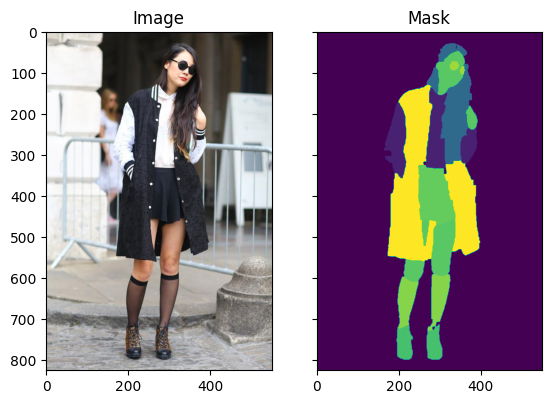

In [167]:
show_image_with_mask(img, mask)

<p class="task" id="3"></p>

3\. Реализуйте архитектуру U-Net. Реализуйте модель таким образом, чтобы на выходе для каждого изображения получался тензор размера `n_classes x h x w`, где `n_classes` - количество уникальных значений в масках, а `h` и `w` - размер исходного изображения. Возьмите один пример из набора данных и пропустите его через сеть. Выведите форму полученного результата на экран.

- [ ] Проверено на семинаре

In [7]:
dloader = DataLoader(dset, batch_size=1)
shapes = []
unique_val = torch.tensor([], dtype=torch.int32)
for i, (img, mask) in enumerate(dloader):
  if i%100 == 0:
    print(img.shape)
  shapes.append(img.shape)
  unique_val = torch.cat([unique_val, torch.unique(mask)])

torch.Size([1, 3, 825, 550])
torch.Size([1, 3, 825, 550])
torch.Size([1, 3, 825, 550])
torch.Size([1, 3, 825, 550])
torch.Size([1, 3, 825, 550])
torch.Size([1, 3, 825, 550])
torch.Size([1, 3, 825, 550])
torch.Size([1, 3, 825, 550])
torch.Size([1, 3, 825, 550])
torch.Size([1, 3, 825, 550])


In [8]:
shapes == [torch.Size([1, 3, 825, 550])]*1000, shapes[0] # h=825, w=550

(True, torch.Size([1, 3, 825, 550]))

In [9]:
unique_val.max() # n_classes=59

tensor(58, dtype=torch.int32)

In [62]:
dloader = DataLoader(dset, batch_size=1)
cnts = torch.zeros(59)

for i, (img, mask) in enumerate(dloader):
  if i%100 == 0:
    print(1)
  idx, cnts_ = torch.unique(mask, return_counts=True)
  cnts[idx] += cnts_

1
1
1
1
1
1
1
1
1
1


In [142]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)

    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])

    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs = v2.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256), dec_chs=(256, 128, 64), num_class=59, retain_dim=False, out_sz=(825,550)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz      = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        return out

In [13]:
model = UNet(retain_dim=True)
print(f"изначальные h, w = {dset[0][0].shape}") # n_channels x h x w
print(f"после применения модели h, w = {model(dset[0][0].unsqueeze(0)).shape}") # batch_size x n_classes x h x w

изначальные h, w = torch.Size([3, 825, 550])
после применения модели h, w = torch.Size([1, 59, 825, 550])


<p class="task" id="4"></p>

4\.  Разбейте набор данных на обучающее и валидационное множество. Обучите модель U-Net для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Обратите внимание, что выборка является несбалансированной. При расчете функции потерь примените любую известную вам технику для работы с несбалансированными выборками.

При создании датасета допускается использовать преобразования, уменьшающие размер изображений (для ускорения процесса обучения).

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре

In [14]:
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

In [15]:
root_imgs = "/content/drive/MyDrive/Учеба/DL/06_cv/png_images/IMAGES"
root_masks = "/content/drive/MyDrive/Учеба/DL/06_cv/png_masks/MASKS"

transforms = v2.Compose([v2.Resize((128,128))])
dset4 = ClothesSegmentationDataset(root_imgs, root_masks, transforms=transforms, mask_transforms=transforms)

img.shape = torch.Size([3, 128, 128])
img.dtype = torch.float32
mask.shape = torch.Size([1, 128, 128])
mask.dtype = torch.int32


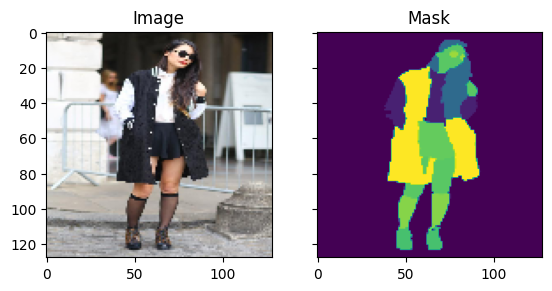

In [16]:
img, mask = dset4[0]
print(f"{img.shape = }")
print(f"{img.dtype = }")
print(f"{mask.shape = }")
print(f"{mask.dtype = }")

show_image_with_mask(img, mask)

In [120]:
weights = cnts.sum()/cnts
weights[weights==np.inf] = cnts.mean()
# weights[weights==np.inf] = 1
weights

tensor([1.3022e+00, 1.1321e+03, 1.1119e+02, 1.3826e+03, 1.6087e+02, 1.1435e+02,
        1.0019e+03, 8.5345e+02, 3.1510e+05, 1.0474e+04, 3.6380e+02, 1.2185e+03,
        7.6907e+06, 3.9803e+01, 3.6513e+01, 7.2024e+05, 1.6603e+04, 2.7001e+04,
        8.8974e+03, 7.9310e+01, 1.0065e+03, 1.0325e+04, 5.7818e+03, 7.6907e+06,
        2.2174e+02, 9.3721e+01, 1.0083e+03, 6.5211e+02, 4.7251e+03, 1.3361e+04,
        7.6907e+06, 4.1367e+01, 6.6698e+03, 2.3761e+02, 2.4084e+05, 4.0826e+02,
        1.5373e+03, 4.2410e+02, 1.5327e+02, 1.1971e+02, 4.5135e+02, 3.4160e+01,
        1.1662e+02, 5.9399e+03, 4.2363e+03, 4.0241e+02, 1.3665e+02, 1.6229e+03,
        1.6982e+02, 8.0422e+02, 7.6907e+06, 2.2404e+02, 9.6295e+03, 5.3123e+03,
        5.6113e+02, 4.0015e+02, 8.2323e+03, 4.0878e+04, 4.6010e+04])

In [169]:
train, test = random_split(dset4, [0.8, 0.2])

train_loader = DataLoader(train, batch_size=32, drop_last=True)
test_loader = DataLoader(test, batch_size=32, drop_last=True)

unet = UNet(retain_dim=True, out_sz=(128,128)).to(device)
lr = 0.001
n_epochs = 30

# initialize loss function and optimizer
lossFunc = CrossEntropyLoss(weight=weights.to(device))
opt = Adam(unet.parameters(), lr=lr)
# calculate steps per epoch for training and test set
trainSteps = len(train) // 32
testSteps = len(test) // 32
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

print("[INFO] training the network...")
startTime = time.time()
for e in range(n_epochs):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(tqdm(train_loader)):
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y.squeeze(1).long())
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in test_loader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y.squeeze(1).long())
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, n_epochs))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))

[INFO] training the network...


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


[INFO] EPOCH: 1/30
Train loss: 2.098728, Test loss: 1.5324


100%|██████████| 25/25 [00:20<00:00,  1.21it/s]


[INFO] EPOCH: 2/30
Train loss: 1.532588, Test loss: 1.5079


100%|██████████| 25/25 [00:22<00:00,  1.12it/s]


[INFO] EPOCH: 3/30
Train loss: 1.522413, Test loss: 1.5095


100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


[INFO] EPOCH: 4/30
Train loss: 1.520126, Test loss: 1.5067


100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


[INFO] EPOCH: 5/30
Train loss: 1.515556, Test loss: 1.5038


100%|██████████| 25/25 [00:20<00:00,  1.20it/s]


[INFO] EPOCH: 6/30
Train loss: 1.513001, Test loss: 1.5027


100%|██████████| 25/25 [00:20<00:00,  1.21it/s]


[INFO] EPOCH: 7/30
Train loss: 1.510828, Test loss: 1.5022


100%|██████████| 25/25 [00:21<00:00,  1.18it/s]


[INFO] EPOCH: 8/30
Train loss: 1.507740, Test loss: 1.5014


100%|██████████| 25/25 [00:21<00:00,  1.16it/s]


[INFO] EPOCH: 9/30
Train loss: 1.505436, Test loss: 1.4982


100%|██████████| 25/25 [00:20<00:00,  1.24it/s]


[INFO] EPOCH: 10/30
Train loss: 1.502766, Test loss: 1.4962


100%|██████████| 25/25 [00:20<00:00,  1.24it/s]


[INFO] EPOCH: 11/30
Train loss: 1.502162, Test loss: 1.4965


100%|██████████| 25/25 [00:20<00:00,  1.20it/s]


[INFO] EPOCH: 12/30
Train loss: 1.501402, Test loss: 1.4952


100%|██████████| 25/25 [00:21<00:00,  1.19it/s]


[INFO] EPOCH: 13/30
Train loss: 1.499563, Test loss: 1.4941


100%|██████████| 25/25 [00:20<00:00,  1.24it/s]


[INFO] EPOCH: 14/30
Train loss: 1.497972, Test loss: 1.4934


100%|██████████| 25/25 [00:20<00:00,  1.23it/s]


[INFO] EPOCH: 15/30
Train loss: 1.497667, Test loss: 1.4933


100%|██████████| 25/25 [00:21<00:00,  1.17it/s]


[INFO] EPOCH: 16/30
Train loss: 1.497107, Test loss: 1.4929


100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


[INFO] EPOCH: 17/30
Train loss: 1.496216, Test loss: 1.4924


100%|██████████| 25/25 [00:20<00:00,  1.22it/s]


[INFO] EPOCH: 18/30
Train loss: 1.495230, Test loss: 1.4919


100%|██████████| 25/25 [00:20<00:00,  1.20it/s]


[INFO] EPOCH: 19/30
Train loss: 1.494151, Test loss: 1.4913


100%|██████████| 25/25 [00:21<00:00,  1.18it/s]


[INFO] EPOCH: 20/30
Train loss: 1.492967, Test loss: 1.4910


100%|██████████| 25/25 [00:20<00:00,  1.24it/s]


[INFO] EPOCH: 21/30
Train loss: 1.491045, Test loss: 1.4902


100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


[INFO] EPOCH: 22/30
Train loss: 1.490315, Test loss: 1.4906


100%|██████████| 25/25 [00:20<00:00,  1.20it/s]


[INFO] EPOCH: 23/30
Train loss: 1.488365, Test loss: 1.4906


100%|██████████| 25/25 [00:21<00:00,  1.17it/s]


[INFO] EPOCH: 24/30
Train loss: 1.488371, Test loss: 1.4901


100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


[INFO] EPOCH: 25/30
Train loss: 1.485746, Test loss: 1.4891


100%|██████████| 25/25 [00:20<00:00,  1.24it/s]


[INFO] EPOCH: 26/30
Train loss: 1.483911, Test loss: 1.4899


100%|██████████| 25/25 [00:21<00:00,  1.16it/s]


[INFO] EPOCH: 27/30
Train loss: 1.482014, Test loss: 1.4885


100%|██████████| 25/25 [00:21<00:00,  1.18it/s]


[INFO] EPOCH: 28/30
Train loss: 1.479975, Test loss: 1.4873


100%|██████████| 25/25 [00:20<00:00,  1.24it/s]


[INFO] EPOCH: 29/30
Train loss: 1.477928, Test loss: 1.4936


100%|██████████| 25/25 [00:20<00:00,  1.22it/s]


[INFO] EPOCH: 30/30
Train loss: 1.476171, Test loss: 1.4918


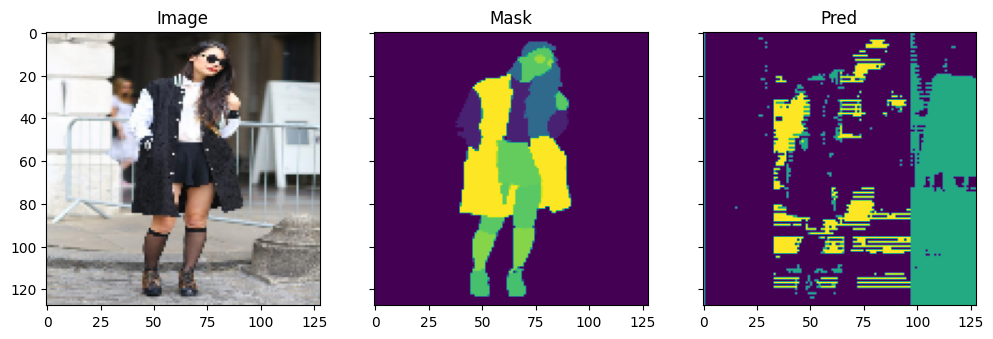

In [173]:
pred = unet(dset[0][0].unsqueeze(0).to(device))
show_image_with_mask(dset4[0][0], dset4[0][1], pred.argmax(dim=1).int().cpu()) #

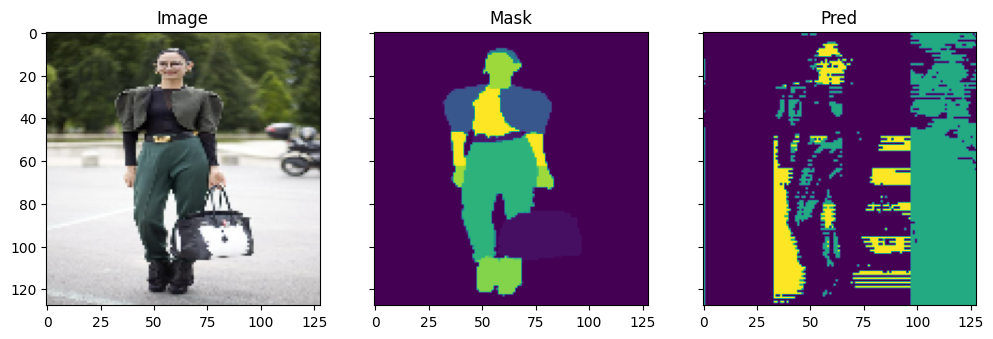

In [171]:
pred = unet(dset[12][0].unsqueeze(0).to(device))
show_image_with_mask(dset4[12][0], dset4[12][1], pred.argmax(dim=1).int().cpu()) #

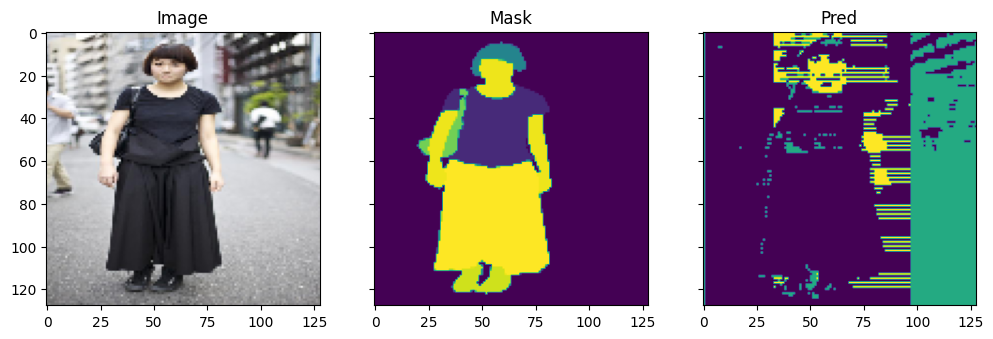

In [182]:
pred = unet(dset[6][0].unsqueeze(0).to(device))
show_image_with_mask(dset4[6][0], dset4[6][1], pred.argmax(dim=1).int().cpu()) #

<p class="task" id="5"></p>

5\.  Обучите модуль `SegformerForSemanticSegmentation` из пакета `transformers` для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Для оптимизации используйте значение функции потерь, которое возвращает вам модель.

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре

## Обратная связь
- [ ] Хочу получить обратную связь по решению